# NeuroMANCER Variable, Constraint, and Objective tutorial

This script demonstrates how to create NeuroMANCER variables, constraints, and objectives
allowing to formulate a broad class of constrained optimization problems.

Variable is basic symbolic abstraction in NeuroMANCER allowing composition of symbolic computational graphs.
Constraint and Objective  are used to construct custom physics-informed loss functions terms
for subsequent gradient-based optimization of the symbolic computational graph.


### Install (Colab only)
Skip this step when running locally.

In [ ]:
!pip install git+https://github.com/pnnl/neuromancer.git@master

### Import

In [1]:
import torch
from neuromancer.constraint import variable, Objective

## Variable

**Variable** is an abstraction that allows for the definition of constraints and objectives with some nice
syntactic sugar. When a Variable object is called given a dictionary a pytorch tensor is returned, and when
a Variable object is subjected to a comparison operator a Constraint is returned. Mathematical operators return
Variables which will instantiate and perform the sequence of mathematical operations. PyTorch callables
called with variables as inputs return variables. Variable supports binary infix operators (variable * variable, variable * numeric): +, -, *, @, **, <, <=, >, >=, ==, ^

There are several ways how to instantiate variable:

In [2]:
# 1, named Variable without trainable tensor value
#   intented to be used as a symbolic handler for input data or model outputs
x1 = variable('x')
# evaluate forward pass of the variable with dictionary input data
print(x1({'x': 5.00}))

5.0


In [15]:
# 2a, unnamed Variable with trainable randomly initialized tensor value
x2 = variable()
print(x2.value)         # torch parameter
print(x2.display_name)  # display name for .show()
print(x2.key)           # uniqye key used to construct computational graph

Parameter containing:
tensor([0.3832], requires_grad=True)
2282673511760
2282673511760


In [16]:
# 2b, named Variable with trainable randomly initialized tensor value
x2_named = variable(display_name='x2')
print(x2_named.value)         # torch parameter
print(x2_named.display_name)  # display name for .show()
print(x2_named.key)           # uniqye key used to construct computational graph

Parameter containing:
tensor([0.1302], requires_grad=True)
x2
2281805243456


In [17]:
# 3a, unnamed Variable with trainable randomly initialized tensor value of specified shape
x3 = variable(3, 3)
print(x3.value.shape)
print(x3.display_name)        # display name for .show()
print(x3.key)                 # uniqye key used to construct computational graph

torch.Size([3, 3])
2281761036304
2281761036304


In [18]:
# 3b, named Variable with trainable randomly initialized tensor value of specified shape
x3_named = variable(3, 3, display_name='x3')
print(x3_named.value.shape)         # shape of torch parameter
print(x3_named.display_name)        # display name for .show()
print(x3_named.key)                 # uniqye key used to construct computational graph

torch.Size([3, 3])
x3
2282673012992


In [20]:
# 4a, unnamed Variable initialized with given tensor
x4 = variable(torch.ones(3, 3))
print(x4.value)
print(x4.value.shape)         # shape of torch parameter
print(x4.display_name)        # display name for .show()
print(x4.key)                 # uniqye key used to construct computational graph

# by defaults its value is not trainable tensor
print(x4.value.requires_grad)
# it can be made trainable tensor
x5 = variable(torch.ones(3, 3, requires_grad=True))
print(x5.value.requires_grad)

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])
torch.Size([3, 3])
2281740926160
2281740926160
False
True


In [21]:
# 4b, named Variable initialized with given tensor
x4_named = variable(torch.ones(3, 3), display_name='x4')
print(x4_named.value.shape)         # shape of torch parameter
print(x4_named.display_name)        # display name for .show()
print(x4_named.key)                 # uniqye key used to construct computational graph

torch.Size([3, 3])
x4
2282672118784


In [6]:
# 5, composite Variable construction via algebraic expression on Variables
x6 = x1 + 1
# evaluate forward pass of the variable with dictionary input data
x6({'x': 1.00})

2.0

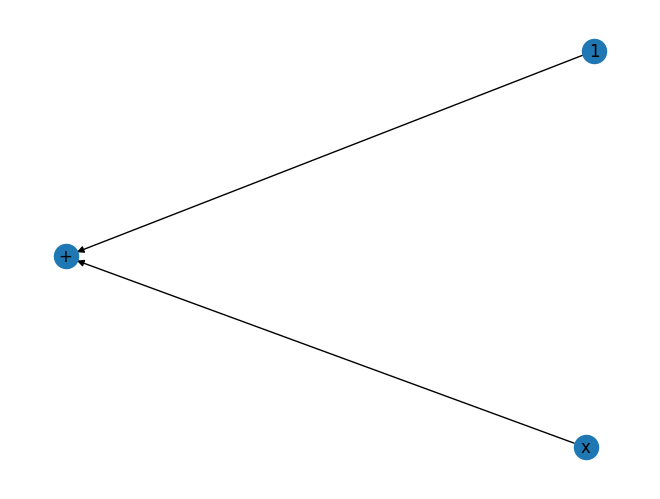

In [7]:
# visualize computational graph of Variable
x6.show()

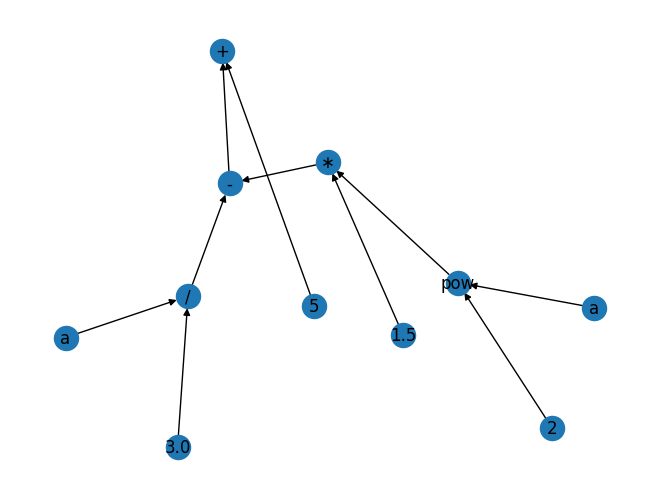

-30.833333333333336


In [8]:
# 5, composite Variable more complex example
a, b = variable('a'), variable('a')
x6 = a/3. - 1.5*b**2 + 5
# visualize computational graph of Variable
x6.show()
# evaluate forward pass of the variable with dictionary input data
print(x6({'a': 5.00, 'b': 3.00}))

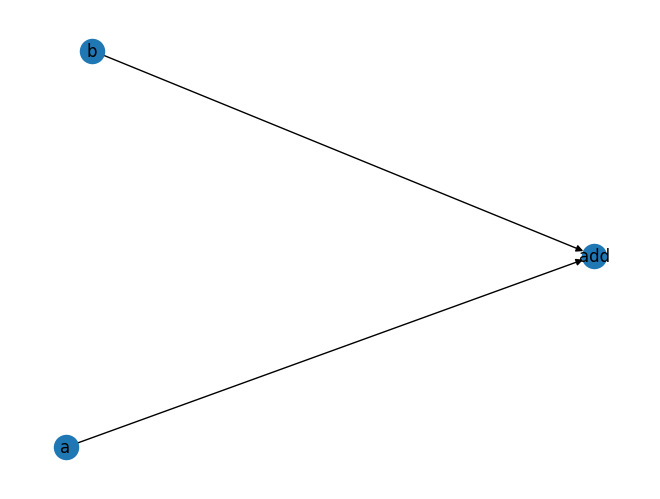

In [9]:
# 6, composite Variable construction via pytorch callables on Variables
x7 = torch.add(variable('a'), variable('b'))
x7.show()  # visualize computational graph of Variable

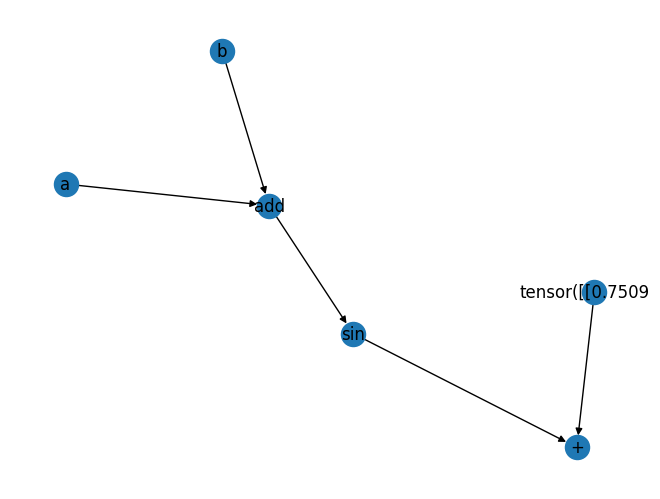

In [10]:
# 6, composite Variable construction via pytorch callables on Variables
x8 = torch.sin(x7) + torch.randn(1, 1)
x8.show()  # visualize computational graph of Variable

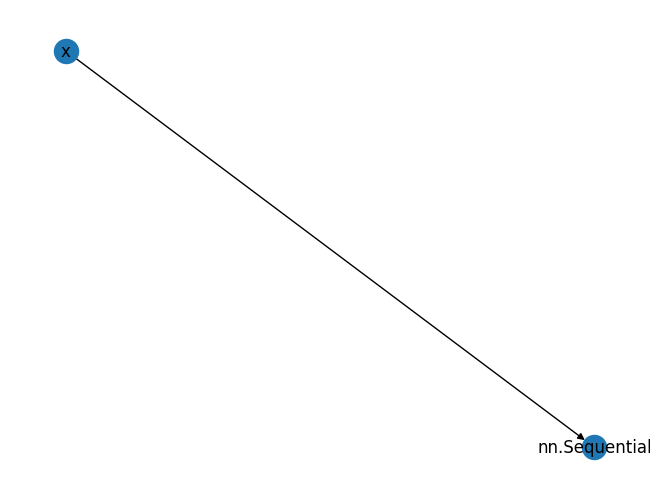

In [11]:
# 7, composite Variable construction with arbitrary function and arbitrary inputs

# Variable wrapping torch.nn module with Variable inputs
x9 = variable([variable('x')], torch.nn.Sequential(torch.nn.Linear(1, 1)),
               display_name='nn.Sequential')
# Note: display_name argument allows to customize display string to be visualized in the .show() method
x9.show()  # visualize computational graph of Variable

In [12]:
#Variable wrapping arbitrary python callable with Variable inputs
x10 = variable([variable('x'), variable('y')], lambda x, y: x**2 + y,
               display_name='x^2 + y')
# variable keys define expected symbolic inputs to composite variables
print(x10.keys)
# evaluate forward pass of the variable with dictionary input data
print(x10({'x': 5.00, 'y': 5.00}))

['x', 'y']
30.0


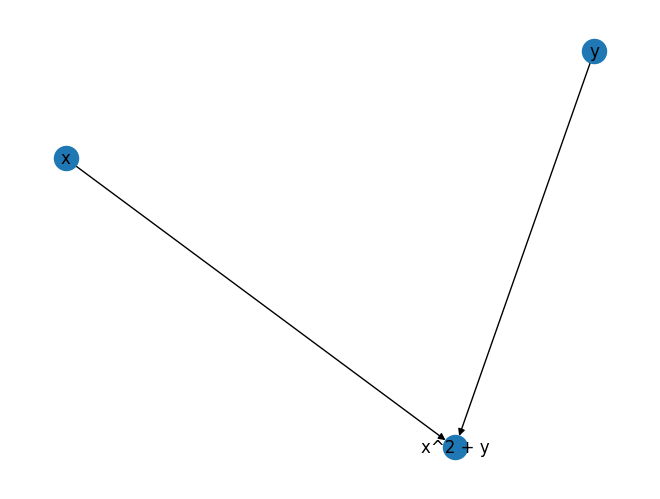

In [13]:
x10.show()  # visualize computational graph of Variable

tensor([-0.0031, -0.8714])


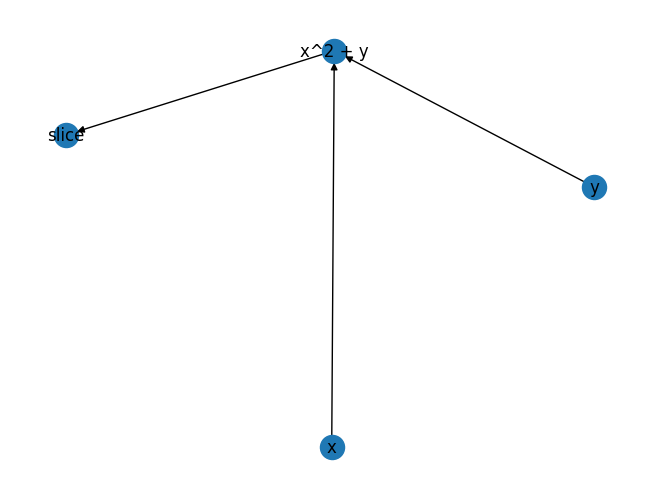

In [14]:
# 8, create new variables via slicing on existing variables
# select column 0
x10_column0 = x10[:, 0]
print(x10_column0({'x': torch.randn(2, 2), 'y': torch.randn(2, 1)}))
x10_column0.show()

tensor([ 1.2057, -0.6255])


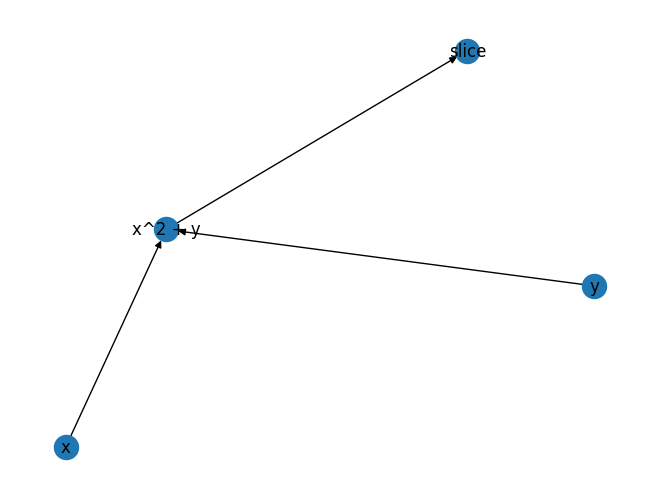

In [15]:
# select column 1
x10_column1 = x10[:, 1]
print(x10_column1({'x': torch.randn(2, 2), 'y': torch.randn(2, 1)}))
x10_column1.show()

## Constraint

**Constraint** is constructed by using comparative infix operators, '<', '>', '==', '<=', '>=' with Variable objects
while '*' is used to weight loss term and '^' to determine l-norm of constraint violation in the loss.       

The forward pass of Constraint returns a dictionary with three elements: loss, value, penalty which are defined
depending on the type of constraint as follows:  
1. equality constraint: g(x) == b  
   * value = g(x) - b  
   * penalty = g(x) - b  
   * loss = metric(penalty)   
2. less than constraint: g(x) <= b  
   * value = g(x) - b  
   * penalty = relu(g(x) - b)  
   * loss = metric(penalty)   
3. greater than constraint: g(x) >= b  
   * value = b - g(x)   
   * penalty = relu(b - g(x))  
   * loss = metric(penalty)        
   
with metric() depending on the norm type: ^1 for L1 norm and ^2 for L2 norm 



In [30]:
# 1, Create a constraint by comparing variable and a constant
con_1 = variable('x') < 1.0
# Evaluate constraint violation at a given value of variable
print(con_1({'x': 5.00}))

{'x_lt_2495455689984': tensor(4.), 'x_lt_2495455689984_value': tensor(4.), 'x_lt_2495455689984_violation': tensor(4.)}


In [31]:
# 2, Create a constraint by comparing variable and variable
# define variables
x, y = variable('x'), variable('y')
# define constraint with 2-norm and weighting factor 100.
con_2 = 100.*(x <= y)^2
# Evaluate constraint violation at a given value of variables
print(con_2({'x': torch.rand(3, 2), 'y': torch.rand(3, 2)}))

{'x_lt_y': tensor(1.8993), 'x_lt_y_value': tensor([[-0.8469, -0.6510],
        [ 0.3376, -0.1083],
        [-0.2314, -0.2492]]), 'x_lt_y_violation': tensor([[0.0000, 0.0000],
        [0.1140, 0.0000],
        [0.0000, 0.0000]])}


In [32]:
# 3, Weighting factor can be a trainable torch parameter
con_3 = torch.nn.Parameter(torch.tensor(0.1))*(variable('x') <= variable('y'))^2
print(con_2({'x': torch.rand(3, 2), 'y': torch.rand(3, 2)}))

{'x_lt_y': tensor(1.7068), 'x_lt_y_value': tensor([[ 0.0302, -0.5817],
        [ 0.3185, -0.8387],
        [ 0.0072, -0.2574]]), 'x_lt_y_violation': tensor([[9.1421e-04, 0.0000e+00],
        [1.0144e-01, 0.0000e+00],
        [5.2062e-05, 0.0000e+00]])}


In [35]:
# 4, Evaluate constraint on algebraic expression of variables
# dataset dictionary with randomly sampled values for variables x and y
data = {'x': torch.rand(1), 'y': torch.rand(1)}
# and define new variable with initial value
a = variable(torch.tensor([1.5]), display_name='a')
# now we create new constraint on algebraic expression
con_4 = (3*x + 1 - 0.5 * a)**2 == 2.0
# and evaluate its aggregate violations on dataset with random variable x
con_4(data)

{'2495458656944_eq_2495458664912': tensor(1.6935),
 '2495458656944_eq_2495458664912_value': tensor([-1.6935]),
 '2495458656944_eq_2495458664912_violation': tensor([1.6935])}

## Objective

**Objective** is constructed via .minimize() method on instantiated Variable object.
It could be also constructed as Objective(variable, metric) with metric being callable such as torch.mean.

In [37]:
# 1, create objective term by via minimize method of Variable
obj_1 = variable('x').minimize()
# Evaluate objective at a given value of variable
print(obj_1({'x': torch.tensor(5.)}))

{'x_<built-in method mean of type object at 0x00007FF933FDC560>': tensor(5.)}


In [38]:
# 2, minimize composite variable
x, y = variable('x'), variable('y')
f = (1 - x) ** 2 + (y - x ** 2) ** 2
obj_2 = f.minimize()
# Evaluate objective at a given value of variables
data = {'x': torch.rand(2,3), 'y': torch.rand(2,3)}
print(obj_2(data))

{'2495458005424_<built-in method mean of type object at 0x00007FF933FDC560>': tensor(0.4045)}


In [39]:
# 3, change metric, weight, and name of the objective
obj_3 = f.minimize(metric=torch.sum, weight=1.0, name='obj')
# Evaluate objective at a given value of variables
print(obj_3(data))

{'2495458005424_<built-in method sum of type object at 0x00007FF933FDC560>': tensor(2.4271)}


In [40]:
# 4, create objective term via Objective interface: this is equivalent to case 3
obj_4 = Objective(f, metric=torch.sum, weight=1.0, name='obj')
# Evaluate objective at a given value of variables
print(obj_4(data))

{'2495458005424_<built-in method sum of type object at 0x00007FF933FDC560>': tensor(2.4271)}
